<sub><sup>Copyright (C) 2025 J. Heinzmann, A. Benady, ETH Zürich</sub></sup>

<sub><sup>
This file is part of the `nlfea` package for the course Computational Mechanics II: Nonlinear FEA at ETH Zurich.
This software is exclusively intended for personal, educational purposes only in the context of the above course.
It must not be used outside of this scope without the explicit consent of the author(s).
</sub></sup>

# Project 1

The first project revolves around truss systems, with the aim to compare the formulation, implementation and numerical results for linear and non-linear kinematics.

This notebook will guide you through all the necessary steps.
We'll start with a linear truss formulation to get you started and make you familiar with how the code works.

## 1. Pre-processing and solver setup


First, we need to import all necessary dependencies.

In [1]:
# external dependencies
import numpy as np
import math

# internal dependencies
from nlfea import Model, Solver, mesh, materials, elements, solution, post

Then, we can start by initializing an empty `Model` object, which will contain all the information about the problem we are going to solve.

In [2]:
model_linear = Model()

Then, we'll assign a standard linear Hooke material law to the model, with Young's modulus of $E=10$ MPa.

In [3]:
model_linear.material = materials.Hooke(E=10)

Next, we create a mesh for a von Mises truss, resembling the one we were dealing with in the exercise session.

In [4]:
(model_linear.nodes, model_linear.connectivity) = mesh.truss.von_mises(B=1, H=1)

We can see that this function created an array storing all the nodal positions as well as the connectivity (i.e. which element is connected to which nodes).

Note that this 

In [5]:
print(f"nodes:\n{model_linear.nodes}")
print(f"element connectivity:\n{model_linear.connectivity}")

nodes:
[[-1.  0.]
 [ 0.  1.]
 [ 1.  0.]]
element connectivity:
[[0 1]
 [1 2]]


Which tells us that the first element (the first row of the lower array) is connected to the nodes with global indices `0` and `1`, while the second element is connected to the nodes with global indices `1` and `2`.

The node with global index `0` (the first row in the upper array, Python starts counting indices at `0`) has the coordinates $(-B,0)$, the node with global index `1` (second row) has the coordinates $(0,H)$, etc.

With this, we can assign an element type to our model (in the library called `parent_element` to avoid confusion of this object with other element instances in e.g. the assembly).

As mentioned, we'll start with linear kinematics by selecting `kinematics = linear`, non-linear kinematics instead would require the argument `kinematics = nonlinear`.

In [6]:
model_linear.parent_element = elements.Bar(kinematics="linear")

Next, we need to define the boundary conditions.

Starting with the Dirichlet boundary conditions (displacement), we will fix the bottom nodes of the truss in both the $x$- and $y$-direction (recall, global node indices `0` and `2`).

In [7]:
bottom_nodes = [0, 2]
model_linear.dirichlet_bcs = (("fix_X", bottom_nodes), ("fix_Y", bottom_nodes))

Navigate to the file `nlfea/constraints/dirichlet_bcs.py` and read the docstring of the function and relate its definition back to the above definition.
In this file, you find missing lines of code, which will be your first task of this project:

**TASK 1**: Add the missing lines of code for both functions in the file `nlfea/constraints/dirichlet_bcs.py` to account for the Dirichlet boundary conditions in the FE equation system.

Next, we add the spring to the top node of the truss system, to replicate the system discussed in the first exercise session.

In [8]:
model_linear.spring_bcs = (
    ("k_Y", [1], model_linear.material.E * model_linear.parent_element.A / 2),
)

Make yourself familiar with the above definition by reading the docstring in the file `nlfea/constraints/spring_bcs.py`. There, you'll find the second task of this project:

**TASK 2**: Add the missing lines of code in the file `nlfea/constraints/spring_bcs.py` to account for springs in the FE equation system.

To complete our problem definition, we need to apply a point load.
The interface to do so is similar to the Dirichlet BCs and springs.

In [9]:
model_linear.point_loads = (("F_Y", [1], -10),)

With this, we can devote ourselves to defining the solution procedure.
For this, we initialize an empty `Solver` object, which will contain all definitions the incremental-iterative solution procedure will need.
Specifically, these are:

- `num_increments`: how many load steps in total we want to apply from the initial state to the final state (in this case the maximum force value),
- `tolerance_nr`: the tolerance at which the iterative Newton-Raphson solver will stop,
- `max_iter`: the maximum number of iterations we allow for the Newton-Raphson solver, and
- `control_method`: for now, we use a force-controlled procedure, but this setting will become important later on in the course.

Familiarize yourself with the other solver options by looking at the solver class in `nlfea/solver.py`.

In [10]:
solver_linear = Solver()
solver_linear.num_increments = 100
solver_linear.tolerance_nr = 1e-7
solver_linear.max_iter = 50
solver_linear.control_method = "load"

Later, we want to create a force-displacement plot from the numerical solution.
For this, we want to track the numerical displacement value (since we know the force value, as we impose it explicitly) during the solution process.

To track this value, we need to specify at which DOF we want to record the displacement.
We want to use the top node of the truss system (where the spring is) for this, and use the displacement in $y$-direction.

**TASK 3:** Determine the correct monitoring DOF.

In [11]:
solver_linear.monitoring_dof = 3
# I guess no other way than to hard code this, as it is part of problem statement?

Before we can start the solution procedure now, we must specify an output directory, where the solver will store the results (now only the displacement, later this will become strain fields, stress fields, etc.).

In [12]:
solver_linear.result_dir = "project1_linear"

With this, we have defined everything and we have to call `model_linear.prepare()` to set up everything internally.
This will also print some statistics, e.g. how many nodes, elemnents and DOFs our model features.

In [13]:
model_linear.prepare()

model dimension:		2
chosen element:			bar
number of nodes:		3
number of elements:		2
number of DOFs:			6



## 2. Incremental-iterative solution

With all our definitions, we can start the iterative solution for each subsequent load step.

Familiarize yourself with the iterative solution procedure in `nlfea/solution/incremental.py` which will call the iterative Newton-Raphson solver in `nlfea/solution/newton_raphson.py` at each increment.

In [14]:
solution.incremental.solve(model_linear, solver_linear)

___________________________________________________________________________ 
increment: 0
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.0
___________________________________________________________________________ 
increment: 1
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.0
___________________________________________________________________________ 
increment: 2
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=5.551115123125784e-16
___________________________________________________________________________ 
increment: 3
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.0
___________________________________________________________________________ 
increment: 4
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.0
___________________________________________________________________________ 
increment: 5
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.0
__________________________________

The solver prints its convergence information for each increment.

For a better understanding, we visualize the residual norms for each iteration, and for each increment in a plot.
For your convenience, the library contains a function which will do so based on the recorded values during the incremental-iterative solution.

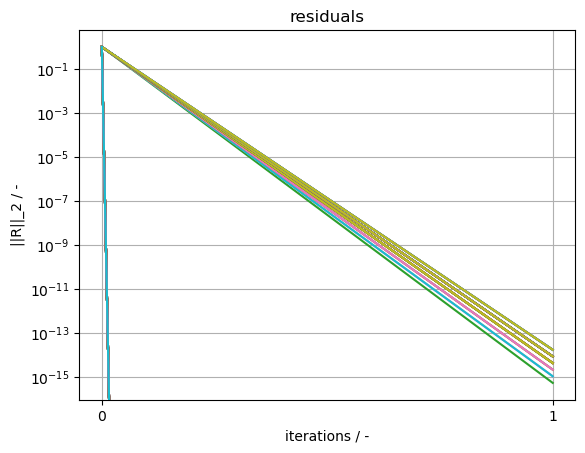

In [15]:
post.plots.residuals(solver_linear.monitoring)

**TASK 4:** What can you observe in terms of convergence behavior, and how can this be explained?
Answer in the Markdown text field below.

We can observe very fast convergence -  this is due to the fact that we're actually solving a linear problem. We have seen in class (and in Prof. Kochmann's class) that in the linear case, the solution found in one iteration.
(Residuals on the order of e-14 are just a numerical artifact)

## 3. Post-processing

As mentioned earlier, we also want to plot the numerically obtained force-displacement response.
The function which will plot the force and displacement values at the specified monitoring DOF accepts as optional argument a function call, which will plot on top a closed-form solution to compare against.
This function is provided below for the case of the von Mises truss with linearized kinematics.

If everything is correct, both of them should align.

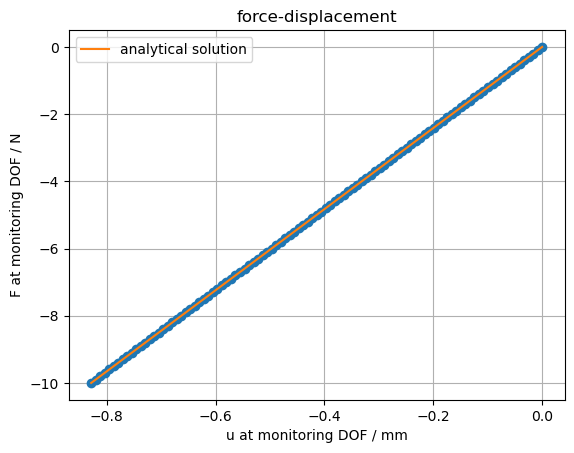

In [16]:
def analytical_solution_linear(u):
    return (
        2
        * model_linear.material[0].E
        * model_linear.parent_element.A
        * (math.sqrt(2) / 2) ** 3
        * u
        + model_linear.spring_bcs[0][2] * u
    )


post.plots.force_displacement(solver_linear.monitoring, analytical_solution_linear)

**TASK 5:** What can you observe in terms of force-displacement behavior, and how can this be explained?
Answer in the Markdown text field below.

The plot illustrates perfect agreement of numerical and analytical solution: in this case a linear relationship between force and displacement. This is what we expect as we are solving a linear problem. (Ktan does not change as a function of U, so we have a constant slope)

Finally, we want to visualize the truss and how it is deformed during the increments.
The library contains a function for this, to which we need to pass our ealier defined output directory containing [`vtk` files](https://docs.vtk.org/en/latest/design_documents/VTKFileFormats.html) with the mesh, and the solution for each increment.
This is a open-source file format, which is also often used in research.
Alternatively (for larger data sets), these files can also be visualized with the open-source program [ParaView](https://www.paraview.org/).

Below, you can go through the different increments with the slider on top.

In [17]:
post.interactive.truss(solver_linear.result_dir)

Widget(value='<iframe src="http://localhost:53177/index.html?ui=P_0x286ec24f620_0&reconnect=auto" class="pyvis…

## Truss elements with non-linear kinematics

Now that you're familiar with the code, we want to devote ourselves to trusses with non-linear kinematics.
We set up everything exactly as above, with the difference that we select non-linear kinematics for the element (internally, this will call another function during the assembly procedure).

In [18]:
# initialize empty model object
model_nonlinear = Model()

# define material
model_nonlinear.material = materials.Hooke(E=10)

# generate mesh
(model_nonlinear.nodes, model_nonlinear.connectivity) = mesh.truss.von_mises(B=1, H=1)

# define element type
model_nonlinear.parent_element = elements.Bar(kinematics="nonlinear")

# define boundary conditions (reusing definitions from linear model above)
model_nonlinear.dirichlet_bcs = (("fix_X", bottom_nodes), ("fix_Y", bottom_nodes))
model_nonlinear.spring_bcs = (
    ("k_Y", [1], model_nonlinear.material.E * model_nonlinear.parent_element.A / 2),
)
model_nonlinear.point_loads = (("F_Y", [1], -10),)
model_nonlinear.prepare()

# define solver
solver_nonlinear = Solver()
solver_nonlinear.num_increments = 100
solver_nonlinear.tolerance_nr = 1e-7
solver_nonlinear.max_iter = 50
solver_nonlinear.control_method = "load"
solver_nonlinear.monitoring_dof = (
    solver_linear.monitoring_dof
)  # same monitoring node as for linear model
solver_nonlinear.result_dir = "project1_nonlinear"

model dimension:		2
chosen element:			bar
number of nodes:		3
number of elements:		2
number of DOFs:			6



**TASK 6:** Complete the assembly function of the bar element with non-linear kinematics `Fint_Ktan_nonlinearkinematics` in `nlfea/elements/bar.py`.

The necessary output arguments for the assembly function in `nlfea/solution/assemble.py` (which will loop over all the elements) are `Fint_elem` and `Ktan_elem`.

Once you've done that, start the incremental-iterative solution process.

In [19]:
solution.incremental.solve(model_nonlinear, solver_nonlinear)

___________________________________________________________________________ 
increment: 0
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.007259119600878106
		iteration: 2, residual_norm=3.916662930092407e-07
		iteration: 3, residual_norm=0.0
___________________________________________________________________________ 
increment: 1
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.00741302003640254
		iteration: 2, residual_norm=4.173143297592219e-07
		iteration: 3, residual_norm=9.43689570931383e-15
___________________________________________________________________________ 
increment: 2
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.0075734490080831725
		iteration: 2, residual_norm=4.452267460264324e-07
		iteration: 3, residual_norm=9.436895709313922e-15
___________________________________________________________________________ 
increment: 3
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=0.007740824680993943
		itera

We again plot the residuals to study the convergence behavior.

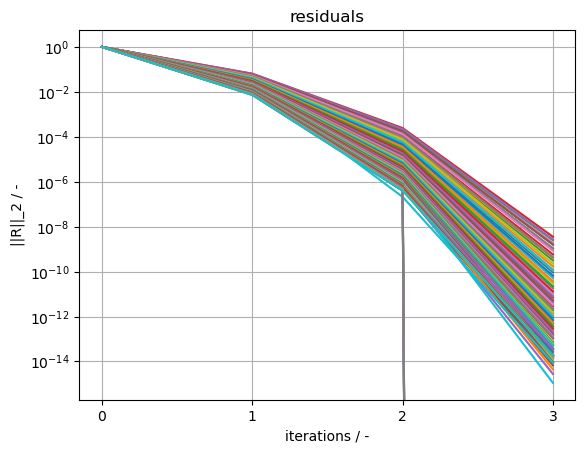

In [20]:
post.plots.residuals(solver_nonlinear.monitoring)

**TASK 7:** What can you observe in the convergence plot? How does the convergence of the nonlinear formulation compare to the linear formulation? Answer in the Markdown cell below.

This convergence plot paints a very different picture compared to the linear one: each time we run the newton-raphson solver, we need 3 iterations to converge (get our residual low enough). This is to be expected, as the problem is now nonlinear, and Ktan now changes with the nodal displacements. 

(Small look ahead: we can see the snap-trough behavior of the structure in the Task 8 Plots. It makes intuitive sense that each for each applied load, we would need to update the Ktan at each new position, as the compression forces in the bars (which have to point in the direction of the bars) point in quite different directions trough their movement)

From the plot, can see that the residual also seems to go down "faster" with each iteration, which is expected as the lecture notes explain we should be getting quadratic convergence.

Finally, we plot the force-displacement response and compare it against the analytical solution.

**TASK 8:** Complete the function giving the force in dependence of the displacement for the von Mises truss system with non-linear kinematics as derived in the exercise session.

Watch out that:

- in the exercise solution, symmetry was used (we only calculated with a single element meaning that you have to scale the reaction force), and
- the force and displacement were both considered to be positive for a downwards movement. This is now the opposite where upwards is positive according to the global coordinate system.

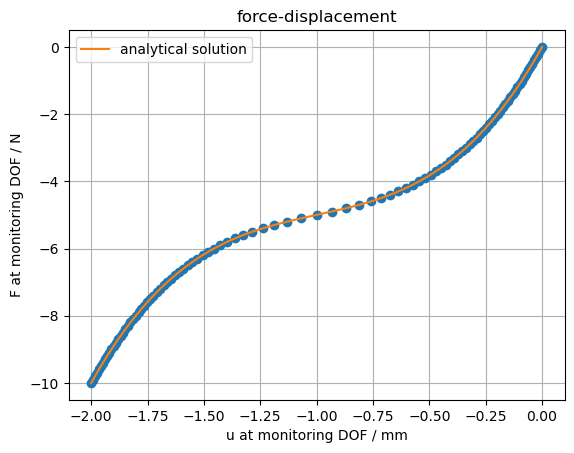

In [21]:
def analytical_solution_nonlinear(u):
    return (
        # from chapter 4 of the lecture notes
        -(2*10*(np.sqrt(2)/2)**3 * (-1/2*u**3 - 3/2*u**2 - u) - 5*u)
    )


post.plots.force_displacement(
    solver_nonlinear.monitoring, analytical_solution_nonlinear
)

Finally, we also visualize the deformation of the truss during the load increments.

In [22]:
post.interactive.truss(solver_nonlinear.result_dir)

Widget(value='<iframe src="http://localhost:53177/index.html?ui=P_0x286f9f55f90_1&reconnect=auto" class="pyvis…

Hand in this notebook with your solutions, as well as the files `nlfea/constraints/dirichlet_bcs.py`, `nlfea/constraints/spring_bcs.py`, `nlfea/elements/bar.py` on Moodle.

⚠️ *Don't change anything else in the library apart the mentioned tasks, otherwise we cannot guarantee that during our grading we can reproduce the same behavior.* ⚠️